In [699]:
# Importing Relevant Libraries for Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [700]:
# Reading in the Dataset and Simplifying Column Names
data = pd.read_csv("Heart_health.csv")
data.rename(columns = {
    'creatinine_phosphokinase' : 'cph',
    'ejection_fraction' : 'ejf',
    'high_blood_pressure' : 'hbp',
    'serum_creatinine' : 'creatinine',
    'serum_sodium' : 'sodium',
}, inplace = True)

data['platelets'] = data['platelets'].astype(int)

# Serum Sodium to Serum Creatinine Ratio
data['scr'] = data['sodium'] / data['creatinine']

# Estimate for CKD-EPI Glomerular Filtration Rate
def pseudoGFR(d):
    sex_factor = 0.9 if d['sex'] == 1 else 1.2
    return (140 - d['age']) / (d['creatinine'] * sex_factor)
    
data['gfr'] = data.apply(pseudoGFR, axis = 1)

# Interaction Terms trying to catch Relationships in Data
data['ejf_age'] = data['age'] * data['ejf']
data['gfr_scr'] = data['gfr'] * data['scr']

# Set DEATH_EVENT as Target Variable
outcome = data['DEATH_EVENT']
data.drop(['time', 'DEATH_EVENT'], axis = 1, inplace = True)

# Data Sample
data.head()

,age,anaemia,cph,diabetes,ejf,hbp,platelets,creatinine,sodium,sex,smoking,scr,gfr,ejf_age,gfr_scr
0,75.0,0,582,0,20,1,265000,1.9,130,1,0,68.421053,38.011696,1500.0,2600.800246
1,55.0,0,7861,0,38,0,263358,1.1,136,1,0,123.636364,85.858586,2090.0,10615.243343
2,65.0,0,146,0,20,0,162000,1.3,129,1,1,99.230769,64.102564,1300.0,6360.946746
3,50.0,1,111,0,20,0,210000,1.9,137,1,0,72.105263,52.631579,1000.0,3795.013850
4,65.0,1,160,1,20,0,327000,2.7,116,0,0,42.962963,23.148148,1300.0,994.513032


In [701]:
# Separating and Normalising the Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Separating into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(data, outcome, test_size = 0.2, random_state = 16, shuffle = True)

# Fitting to Training Set and Normalising
logregScaler = MinMaxScaler()
X_train_norm = logregScaler.fit_transform(X_train)
X_test_norm = logregScaler.transform(X_test)

# Sample Data post-Normalisation
X_train_norm[0]

array([0.36363636, 0.        , 0.00468811, 0.        , 0.19642857,
       1.        , 0.20547945, 0.33707865, 0.65714286, 1.        ,
       1.        , 0.09364452, 0.12598791, 0.19463087, 0.0213103 ])

In [702]:
# Performing Logistic Regression
from sklearn.linear_model import LogisticRegression

# Max 1000 iterations during Training, with Light L2 Regularisation to fight Overfitting
lReg = LogisticRegression(max_iter = 1000, penalty = 'l2', C = 0.75)
lReg.fit(X_train_norm, y_train)

# Capture the Weights from the Model
feature_weights = lReg.coef_[0]
feature_names = data.columns

# Sort Features by Magnitude of Contribution to Model Predictions
weights_df = pd.DataFrame({
    'Feature' : feature_names,
    'Weight' : feature_weights,
    'Importance': abs(feature_weights)
}).sort_values(by = 'Importance', ascending = False)

# Output Features in order of Importance
print(weights_df)

# Positive Weights describe Positive Correlations
# Negative Weights describe Negative Correlations
# Higher Magnitudes contribute more greatly to the Model

       Feature    Weight  Importance
4          ejf -1.531240    1.531240
0          age  1.214066    1.214066
12         gfr -1.189608    1.189608
11         scr -1.105811    1.105811
7   creatinine  0.741493    0.741493
2          cph  0.688977    0.688977
14     gfr_scr -0.669674    0.669674
8       sodium -0.589405    0.589405
13     ejf_age -0.426772    0.426772
5          hbp  0.389505    0.389505
6    platelets -0.328075    0.328075
1      anaemia  0.201940    0.201940
10     smoking  0.104121    0.104121
3     diabetes -0.071684    0.071684
9          sex -0.004714    0.004714


In [703]:
# Calculating the accuracy of Model
from sklearn.metrics import classification_report, accuracy_score

# Accuracy on Training Set
y = lReg.predict(X_train_norm)
acc_lreg_train = accuracy_score(y_train, y) * 100
print(f"Train Set Classification Report:\n{classification_report(y, y_train)}")
print(f"Train Set Accuracy Score: {acc_lreg_train:.2f}%")

# Accuracy on Test Set (Cross-Validation)
y_pred = lReg.predict(X_test_norm)
acc_lreg_test = accuracy_score(y_test, y_pred) * 100
print(f"Test Set Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Test Set Accuracy Score: {acc_lreg_test:.2f}%")

Train Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       194
           1       0.42      0.73      0.53        45

    accuracy                           0.76       239
   macro avg       0.67      0.75      0.68       239
weighted avg       0.83      0.76      0.78       239

Train Set Accuracy Score: 75.73%
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        43
           1       0.62      0.59      0.61        17

    accuracy                           0.78        60
   macro avg       0.73      0.72      0.73        60
weighted avg       0.78      0.78      0.78        60

Test Set Accuracy Score: 78.33%


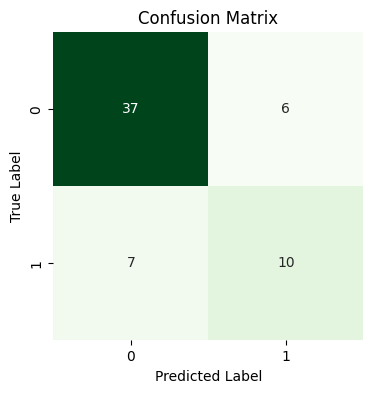

In [704]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4, 4))

# Colormap highlighting where Model performs most effectively
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Greens', cbar = False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [705]:
# Performing PCA
from sklearn.decomposition import PCA

# Finding the Number of Components that maintains 99% Variance in the Data
pca = PCA(n_components = 0.99)
pca.fit(X_train_norm)
print(f"Minimum Principle Components for 99% Variance: {pca.n_components_}")

Minimum Principle Components for 99% Variance: 11


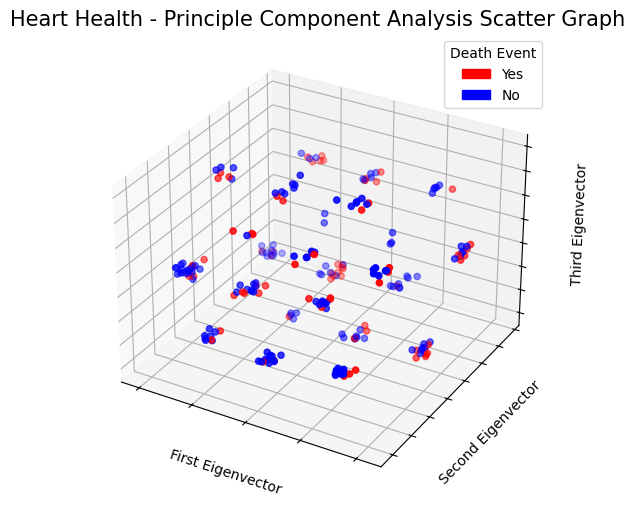

In [706]:
# Performing PCA on Training and Testing Data
import matplotlib.patches as mpatches

X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

# Colours and Labels for DEATH_EVENT on Data Points
c_map = { 1 : "red", 0 : "blue" }
l_map = ["No", "Yes"]

# Creating a 3D figure displaying most important Principle Components
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection = '3d')
ax.set_title('Heart Health - Principle Component Analysis Scatter Graph', size = 15)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c = y_train.map(c_map))

# Axis Labels
ax.set_xlabel('First Eigenvector')
ax.set_ylabel('Second Eigenvector')
ax.set_zlabel('Third Eigenvector')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Graph Legend
legend = [mpatches.Patch(color = color, label = l_map[label]) for label, color in c_map.items()]
ax.legend(handles = legend, title = "Death Event")

plt.show()

In [707]:
# Reducing to most important Features
important_features = ['ejf', 'age', 'gfr', 'scr']
selected_data = data[important_features]

# Resaparating Data
X_train, X_test, y_train, y_test = train_test_split(selected_data, 
                                                    outcome, 
                                                    test_size = 0.2, 
                                                    random_state = 64)

# Normalising Data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm[0]

array([0.16666667, 0.34545455, 0.55843949, 0.4618176 ])

In [708]:
# Training the different SVC models
from sklearn import svm

svc = svm.SVC(kernel = 'linear', C = 0.5).fit(X_train_norm, y_train)
y_pred_lin = svc.predict(X_test_norm)
y_lin = svc.predict(X_train_norm)

acc_lin_train = accuracy_score(y_train, y_lin) * 100
acc_lin_test = accuracy_score(y_test, y_pred_lin) * 100

print(f"Train Set Accuracy Score: {acc_lin_train:.2f}%")
print(f"Test Set Accuracy Score: {acc_lin_test:.2f}%")


Train Set Accuracy Score: 72.80%
Test Set Accuracy Score: 81.67%


In [709]:
svc = svm.SVC(kernel = 'poly', C = 0.5).fit(X_train_norm, y_train)
y_pred_poly = svc.predict(X_test_norm)
y_poly = svc.predict(X_train_norm)

acc_poly_train = accuracy_score(y_train, y_poly) * 100
acc_poly_test = accuracy_score(y_test, y_pred_poly) * 100

print(f"Train Set Accuracy Score: {acc_poly_train:.2f}%")
print(f"Test Set Accuracy Score: {acc_poly_test:.2f}%")

Train Set Accuracy Score: 78.24%
Test Set Accuracy Score: 78.33%


In [710]:
svc = svm.SVC(kernel = 'rbf', C = 0.5).fit(X_train_norm, y_train)
y_pred_rbf = svc.predict(X_test_norm)
y_rbf = svc.predict(X_train_norm)

acc_rbf_train = accuracy_score(y_train, y_rbf) * 100
acc_rbf_test = accuracy_score(y_test, y_pred_rbf) * 100

print(f"Train Set Accuracy Score: {acc_rbf_train:.2f}%")
print(f"Test Set Accuracy Score: {acc_rbf_test:.2f}%")

Train Set Accuracy Score: 76.15%
Test Set Accuracy Score: 81.67%


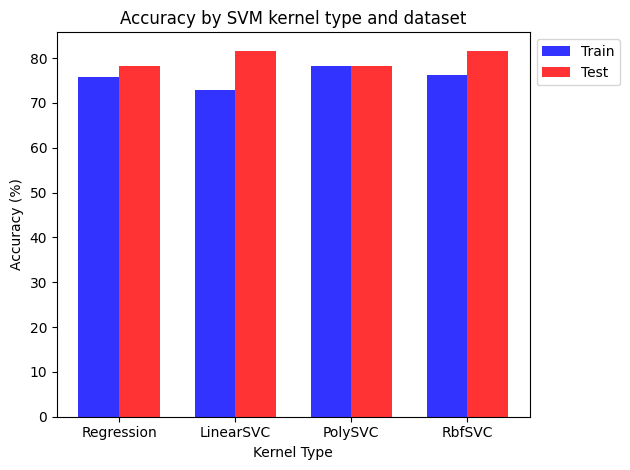

In [711]:
# Bar Chart Displaying Training vs Test Accuracies
train_accuracies = [acc_lreg_train, acc_lin_train, acc_poly_train, acc_rbf_train]
test_accuracies = [acc_lreg_test, acc_lin_test, acc_poly_test, acc_rbf_test]

# Logistic Regression + SVC Kernel Types
kernel_types = ['Regression', 'LinearSVC', 'PolySVC', 'RbfSVC']

fig, ax = plt.subplots()

bar_width = 0.35
opacity = 0.8
index = range(len(train_accuracies))

# Training Accuracies
train_bars = ax.bar(index, train_accuracies, bar_width,
                    alpha=opacity, color='b', label='Train')

# Testing Accuracies
test_bars = ax.bar([p + bar_width for p in index], test_accuracies, bar_width,
                   alpha=opacity, color='r', label='Test')

ax.set_xlabel('Kernel Type')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by SVM kernel type and dataset')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(kernel_types)
ax.legend()

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()